In [2]:
import os
from glob import glob
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import cv2
import numpy as np
from keras.applications import VGG16
from scipy.spatial import distance
from tsp_solver.greedy import solve_tsp

# BASE_DIR = os.path.dirname(os.path.abspath(__file__))
BASE_DIR = os.getcwd()
VGG16_FEATURES = os.path.join(BASE_DIR, 'handwriting_gen_vgg16_features.npy')
IMG_FILES_PATTERN = os.path.join(BASE_DIR, 'data/handwriting_gen/*_crop.jpg')
JSON_FILES_PATTERN = os.path.join(BASE_DIR, 'data/handwriting_gen/*.json')
IMG_ORG_FILES_PATTERN = os.path.join(BASE_DIR, 'data/handwriting/*_crop.jpg')

def _img_files():
    return sorted(glob(IMG_FILES_PATTERN, recursive=True))

def _json_files():
    return sorted(glob(JSON_FILES_PATTERN, recursive=True))

def _img_org_files():
    return sorted(glob(IMG_ORG_FILES_PATTERN, recursive=True))

/home/nghia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
files = _img_files()
print(len(files))
jsons = _json_files()
print(len(jsons))

137
0


In [4]:
# Import Modules
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sys
import tarfile
import seaborn
import random
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import display, Image
from scipy import ndimage
from scipy.misc import imresize
from scipy.io import loadmat
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [5]:
mnist = input_data.read_data_sets('../data/MNIST_data/', one_hot=False)
train_dataset = mnist.train.images
train_labels = mnist.train.labels
test_dataset = mnist.test.images
test_labels = mnist.test.labels
valid_dataset = mnist.validation.images
valid_labels = mnist.validation.labels
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz
Training set (55000, 784) (55000,)
Validation set (5000, 784) (5000,)
Test set (10000, 784) (10000,)


In [6]:
IMAGE_SIZE = 28
NUM_CHANNELS = 1
NUM_LABELS = 10

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)).astype(np.float32)
  labels = labels.astype(np.int32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

# X_tr = train_dataset[:200, :, :, :]
# print('train_dataset', X_tr.shape)
# X_tr_labels = train_labels[:200]
# print('train_dataset', X_tr_labels.shape)

Training set (55000, 28, 28, 1) (55000,)
Validation set (5000, 28, 28, 1) (5000,)
Test set (10000, 28, 28, 1) (10000,)


[0.         0.01176471 0.04313726 0.0509804  0.06666667 0.07450981
 0.08235294 0.09411766 0.1254902  0.12941177 0.17254902 0.1764706
 0.18823531 0.19607845 0.20000002 0.20784315 0.227451   0.23529413
 0.2392157  0.24705884 0.2509804  0.25882354 0.2627451  0.2901961
 0.31764707 0.3372549  0.38823533 0.43137258 0.4784314  0.49411768
 0.5019608  0.5254902  0.5294118  0.53333336 0.5372549  0.5411765
 0.54901963 0.627451   0.6313726  0.6431373  0.6666667  0.6862745
 0.69803923 0.7176471  0.7254902  0.73333335 0.7372549  0.7411765
 0.75294125 0.7843138  0.79215693 0.7960785  0.8078432  0.8117648
 0.81568635 0.8431373  0.86274517 0.89019614 0.9058824  0.909804
 0.9176471  0.92549026 0.94117653 0.9490197  0.9568628  0.9607844
 0.9686275  0.98823535 0.9921569  1.        ]
(28, 28, 3)


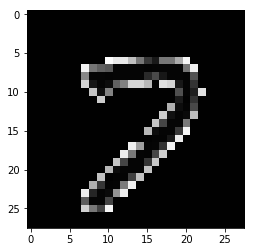

/home/nghia/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:194: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  "Did you mean to use a boolean array?", UserWarning)
/home/nghia/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


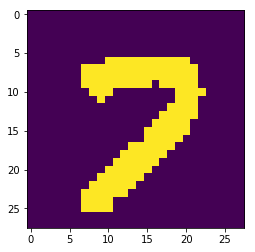

7


In [7]:
from skimage import morphology

rd = 1140
sample = train_dataset[rd,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],)
img = sample.astype(np.float32)
print(np.unique(img))

img = np.stack((img,)*3, -1)
# img = np.invert(img)
imagem = (255-img)
print(imagem.shape)
plt.imshow(imagem)
plt.show()

mask = sample * 255

mask = morphology.remove_small_holes(mask.astype(np.int32)).astype(bool)

plt.imshow(mask)
plt.show()

print(train_labels[rd])

In [8]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 3))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
#         plt.xticks([])
#         plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

In [9]:
def _resize_img(file):
#     print(file)
    img = cv2.imread(os.path.join(BASE_DIR, "%s" % file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(img, (128, 64))
    return resized

(64, 128, 3)


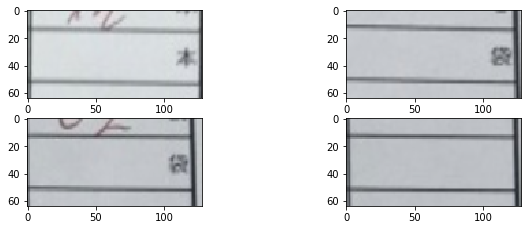

(64, 128, 3)


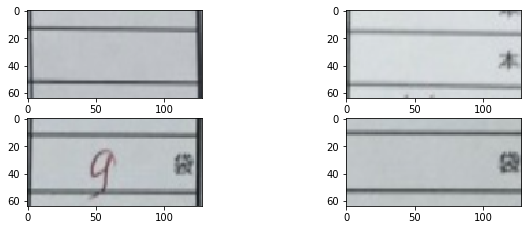

In [10]:
files = np.array(files)
background_images = np.array([_resize_img(f) for f in files])
print(background_images[0].shape)
show_images(background_images[0:4])


original_images = np.array([_resize_img(f) for f in _img_org_files()])
print(original_images[0].shape)
show_images(original_images[6:10])

In [11]:
# image is expected be in RGB color space
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([180, 180, 180])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([200, 200,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

# show_images(list(map(select_rgb_white_yellow, wraps)))

In [12]:
from skimage import data, color, io, img_as_float
IMAGE_SIZE = 28
NUM_CHANNELS = 1
NUM_LABELS = 11 # 0-9 and no digit (10)
N = 5 # max number of digits on the sequence
WIDTH = 128
HEIGHT = 64
np.random.seed(42)
NUM_SIZE = 28
alpha = 0.6
x_offset=10
y_offset=20

def create_sequences(images, bk_images, labels, debug=False):  
#     print("images", images.shape)
#     print("bk_images", bk_images.shape)
    length = images.shape[0]
    index = 0
    
    seq_images = np.ndarray([length,HEIGHT,WIDTH,3], dtype='float32')
    seq_masks  = np.ndarray([length,N,HEIGHT,WIDTH], dtype='float32')
    seq_labels = np.ones([length, N], dtype=int) * 10 # init to 10 cause it would be no digit
    emp_mask = np.zeros([NUM_SIZE,NUM_SIZE], dtype='float32')
    emp_sequence = np.zeros([HEIGHT, WIDTH], dtype=int)

    while index < length:
        bk_img = bk_images[random.randint(0, len(bk_images)-1)].copy()
#         print("bk_img", bk_img.shape)
        # Random
        L = random.randint(1, N)
        offset = random.randint(0, length-N)
        # Image
        selected = images[offset:offset+L,:,:,:].copy()
        count = selected.shape[0]
        selected_num = []

        # resize selected num
        for i in range(count):
            num = selected[i].reshape(selected[i].shape[0], selected[i].shape[1],).astype(np.float32) #28x28xL
            resized = imresize(num, (NUM_SIZE,NUM_SIZE))
            selected_num.append(resized) 

        for i in range(count):
            num = selected_num[i]
            emp_count = count-i-1
            masks1 = (emp_mask.copy(),) * i
            masks2 = (emp_mask.copy(),) * emp_count
            a = np.hstack(masks1 + (num,) + masks2)                    
            a = a.reshape(a.shape[0], a.shape[1],).astype(np.float32) #28x28xL
            if a.shape[1] > WIDTH:
                a = imresize(a, (a.shape[0], 100))

            a_mask = morphology.remove_small_holes(a.astype(np.int32)).astype(bool)
            a_emp = emp_sequence.copy()
            a_emp[y_offset:y_offset+a_mask.shape[0], x_offset:x_offset+a_mask.shape[1]] = a_mask
            seq_masks[index, i] = a_emp

        if True:
            show_images(seq_masks[index,0:2])
        sequence = np.hstack(selected_num) #28x28*Lx1
        sequence = sequence.reshape(sequence.shape[0], sequence.shape[1],).astype(np.float32) #28x28xL
        if sequence.shape[1] > WIDTH:
            sequence = imresize(sequence, (sequence.shape[0], 100))
        imagem = (255-sequence)

        added_image1 = bk_img.copy()
        added_image1[y_offset:y_offset+sequence.shape[0], x_offset:x_offset+sequence.shape[1],0] = \
            np.where(imagem < 255, imagem, added_image1[y_offset,x_offset + 10,0])
        added_image1[y_offset:y_offset+sequence.shape[0], x_offset:x_offset+sequence.shape[1],1] = \
            np.where(imagem < 255, imagem, added_image1[y_offset,x_offset + 10,1])
        added_image1[y_offset:y_offset+sequence.shape[0], x_offset:x_offset+sequence.shape[1],2] = \
            np.where(imagem < 255, imagem, added_image1[y_offset,x_offset + 10,2])
        added_image_gray = select_rgb_white_yellow(added_image1)
        if True:
            show_images([added_image1, added_image_gray])
        seq_images[index] = added_image_gray
    
        # Label
        for local_index in range(L):
            seq_labels[index, local_index] = labels[offset+local_index]
        index += 1  
    return seq_images, seq_masks, seq_labels

train_dataset (5, 28, 28, 1)
X_tr_labels (5,)


/home/nghia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/nghia/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:194: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  "Did you mean to use a boolean array?", UserWarning)
/home/nghia/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


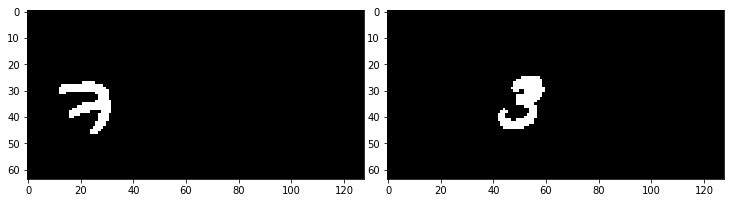

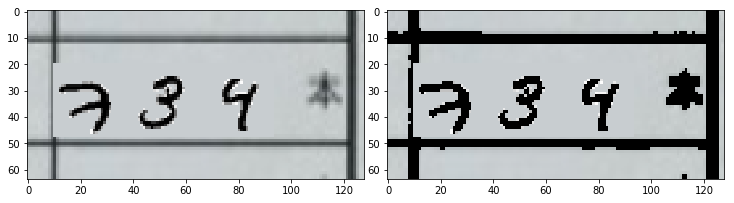

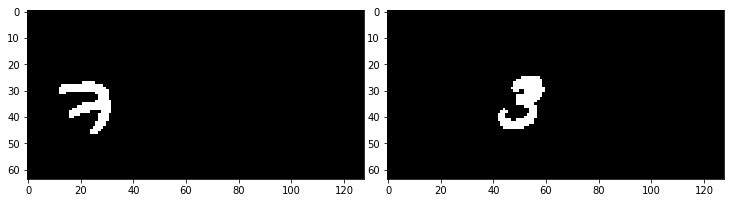

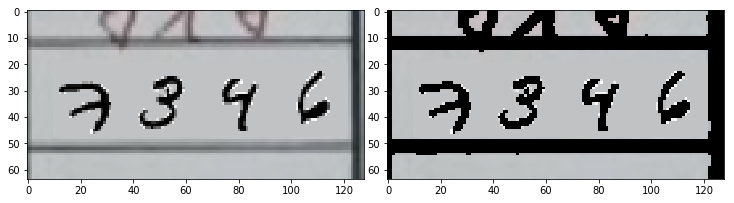

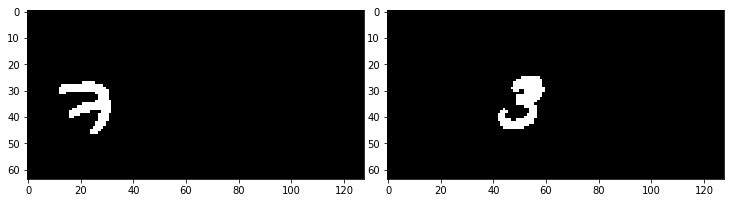

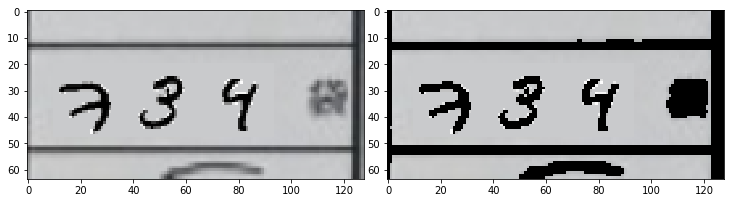

/home/nghia/anaconda3/lib/python3.6/site-packages/matplotlib/image.py:396: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min


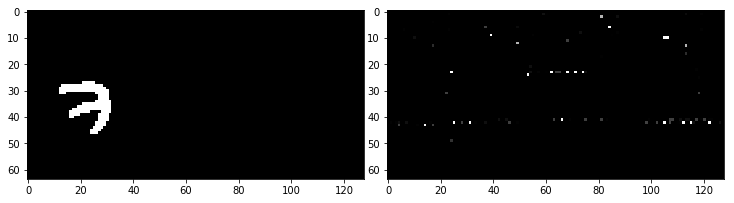

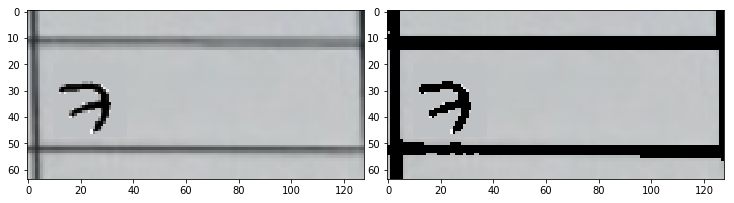

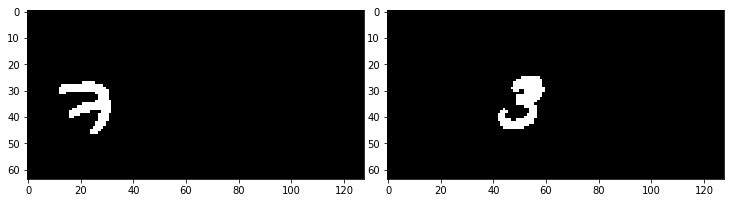

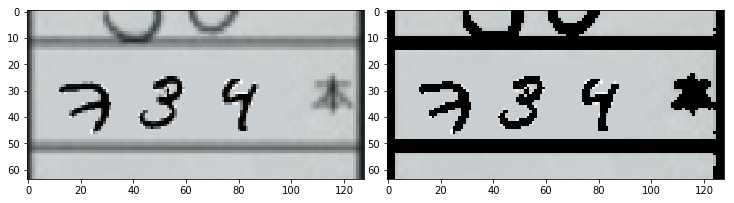

train_dataset (5, 28, 28, 1)
train_dataset (5,)


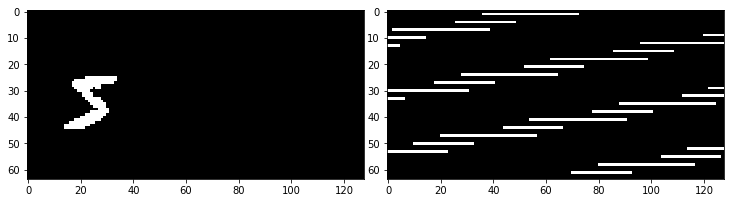

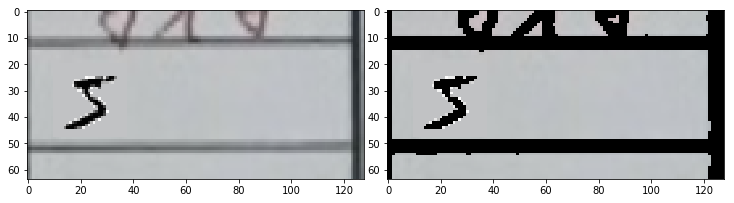

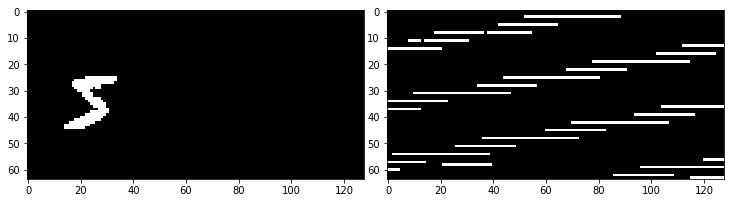

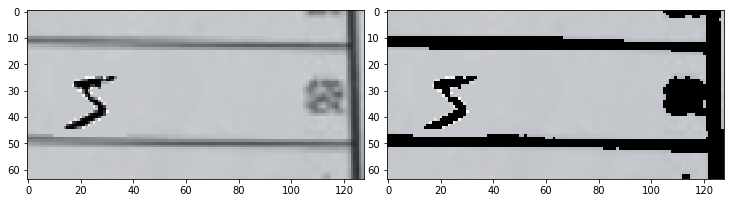

/home/nghia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


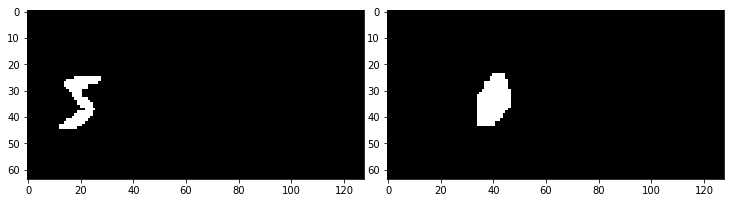

/home/nghia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


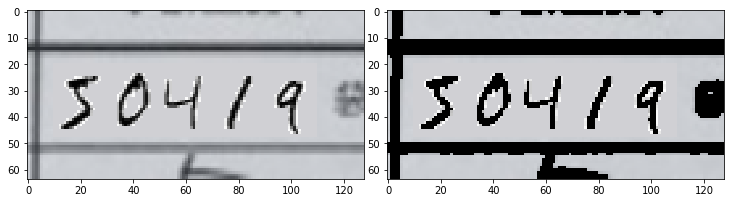

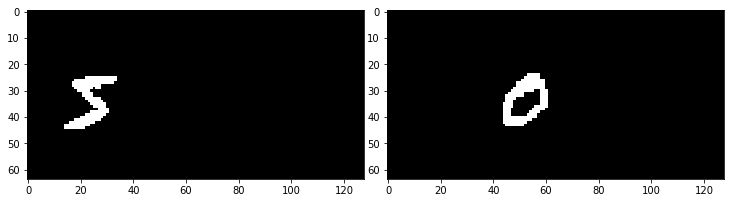

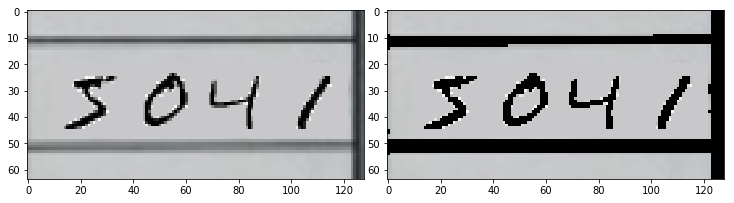

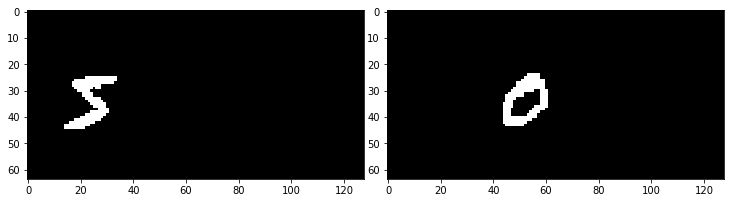

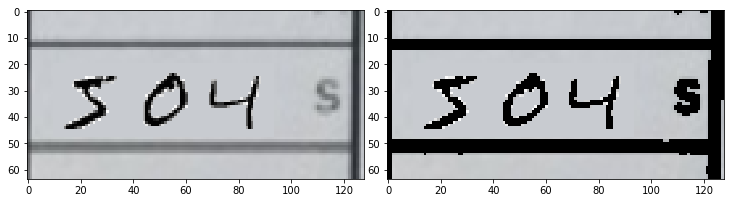

Training set (5, 64, 128, 3) (5, 5, 64, 128) (5, 5)
Validation set (5, 64, 128, 3) (5, 5, 64, 128) (5, 5)


In [13]:
#### bk_images = np.array(imgs)
# print(bk_images[0])

X_tr = train_dataset[:5, :, :, :]
print('train_dataset', X_tr.shape)
X_tr_labels = train_labels[:5]
print('X_tr_labels', X_tr_labels.shape)

train_set, train_set_masks, train_set_labels = create_sequences(X_tr, background_images, X_tr_labels, debug=False)
# test_dataset, test_labels = create_sequences(test_dataset, test_labels)

X_valid = valid_dataset[:5, :, :, :]
print('train_dataset', X_tr.shape)
X_valid_labels = valid_labels[:5]
print('train_dataset', X_tr_labels.shape)
valid_set, valid_set_masks, valid_set_labels = create_sequences(X_valid, background_images, X_valid_labels, debug=False)


print('Training set', train_set.shape, train_set_masks.shape, train_set_labels.shape)
print('Validation set', valid_set.shape, valid_set_masks.shape, valid_set_labels.shape)
# print('Test set', test_dataset.shape, test_labels.shape)  

sample (64, 128, 3)
[  0. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192.
 193. 194. 195. 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206.
 207. 208. 209. 210. 211. 212. 213. 214. 215. 216. 217. 223. 225. 226.
 227. 228. 230. 231. 232. 234. 235. 237. 242. 244. 245. 246. 247. 248.
 250. 251. 253. 254.]


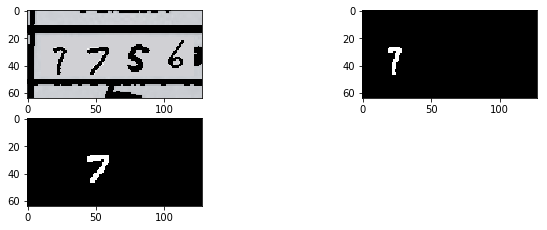

In [16]:
rd = 5
sample = valid_set[rd,:,:,:].copy()
print("sample", sample.shape)
print(np.unique(sample))
# inv = np.invert(sample)
show_images([sample/255, valid_set_masks[rd][0], valid_set_masks[rd][1]])
# sample = sample.reshape(sample.shape[0], sample.shape[1], 3).astype(np.float32)
# sample -= 70
# sample /= 255
# plt.imshow(sample, cmap=None)
# plt.show()

# print(valid_ds_masks[rd].shape)
# plt.imshow(valid_ds_masks[rd][0])
# plt.show()
# print(valid_labels[rd])

In [18]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

os.environ["CUDA_VISIBLE_DEVICES"]="1"

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()
import handwriting_split_data as data_load

IMAGE_PATH = os.path.join(ROOT_DIR, "data/hand/images")
MASK_PATH = os.path.join(ROOT_DIR, "data/hand/masks")

images = data_load.label_images(n_splits=5)
index_train_cv = np.where(images != 0)
index_valid_cv = np.where(images == 0 )
files = data_load._img_json_files()

X_train_cv = np.array([x for x in files if files.index(x) in index_train_cv[0]])
X_valid = np.array([x for x in files if files.index(x) in index_valid_cv[0]])

print(X_train_cv.shape)
print(X_valid.shape)

print(X_train_cv[0])

extract_features
load feature
Loaded VGG16 features:  (70, 512)
sort images
[0 1 2 3 4]
(56,)
(14,)
data/handwriting/000_056_crop.jpg


In [19]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
def load_mask(json_name, json_base_path='', height=64, width=128):
    # print(json_name)
    instance_masks = []
    class_ids = []

    img = np.zeros([height, width], dtype=np.uint8)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    df = pd.read_json(os.path.join(json_base_path, json_name), typ='series')

    # print(df)
    for idx, shape in enumerate(df.shapes):
        class_id = shape['label']
        box = shape['points']
        m = utils.draw_polygon(img.copy(), box, 1)
        resized = cv2.resize(m, (128, 64))
        instance_masks.append(resized)
        class_ids.append(class_id)

    if class_ids:
        masks = np.stack(instance_masks, axis=0)
        class_ids = np.array(class_ids, dtype=np.int32)
#         print("masks", masks.shape)
#         print("class_ids", class_ids.shape)
        return masks, class_ids

In [20]:
def resize_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(img, (128, 64))
    gray = cv2.cvtColor(resized,cv2.COLOR_RGB2GRAY)
    rgb = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
#     gray = cv2.cvtColor(resized,cv2.COLOR_RGB2GRAY)
#     rgb = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
    gray = select_rgb_white_yellow(rgb)
    # resized = cv2.resize(img, (144 * 2, 256 * 2))
    return gray, img.shape

In [21]:
N = 5
width = 64
height = 128
channels = 3

def dataset_gen(X_train_cv):
    length = X_train_cv.shape[0]
    images = []
    masks = []
#     images = np.ndarray([length,width,height,channels])
    masks  = np.ndarray([length,N,width,height], dtype='float32')
    labels = np.ones([length, N], dtype=int) * 10 # init to 10 cause it would be no digit

    # import shutil
    for idx, p in enumerate(X_train_cv):
        img, img_shape = resize_img(p)
#         print(np.unique(img))
#         show_images([img])
        images.append(img)
        base_name = os.path.splitext(os.path.basename(p))[0]
        json_name = "%s.json" % base_name
        msks, class_ids = load_mask(json_name, json_base_path='data/handwriting/', height=img_shape[0], width=img_shape[1])
        for i in range(msks.shape[0]):
            masks[idx, i] = msks[i]

        for i in range(class_ids.shape[0]):
            labels[idx, i] = class_ids[i]
    return images, masks, labels

(56, 64, 128, 3)
(56, 5, 64, 128)
(56, 5)
[ 1  8 10 10 10]


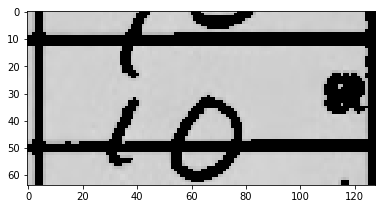

In [24]:
images, masks, labels = dataset_gen(X_train_cv)

print(np.array(images).shape)
print(np.array(masks).shape)
print(np.array(labels).shape)
print(labels[1])
show_images([images[29]/255])
# show_images(masks[1,:2])
# def gray_to(img):
#     gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
#     return cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

# grays = list(map(gray_to, images[29:33]))
# grays1 = list(map(select_rgb_white_yellow, grays))
# show_images(grays1)

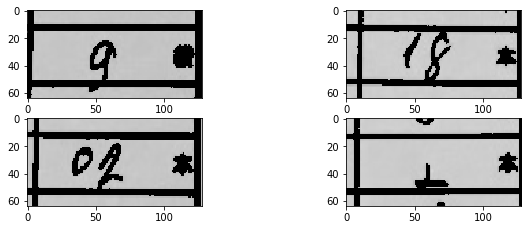

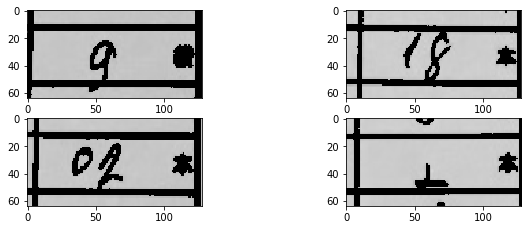

In [25]:
images_gray = list(map(select_rgb_white_yellow, images))

show_images(images_gray[0:4])
show_images(images[0:4])

In [26]:
images1, masks1, labels1 = dataset_gen(X_valid)

print(np.array(images1).shape)
print(np.array(masks1).shape)
print(np.array(labels1).shape)
print(labels1[1])

(14, 64, 128, 3)
(14, 5, 64, 128)
(14, 5)
[ 7 10 10 10 10]


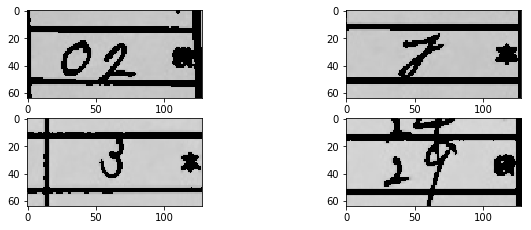

In [27]:
images1_gray = list(map(select_rgb_white_yellow, images1))

show_images(images1_gray[0:4])

sample (64, 128, 3)
[  0 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 207 208 209]


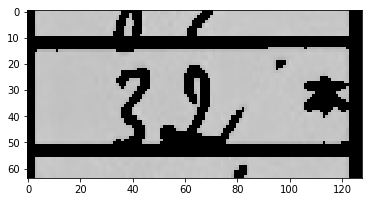

(5, 64, 128)


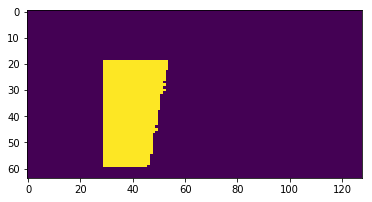

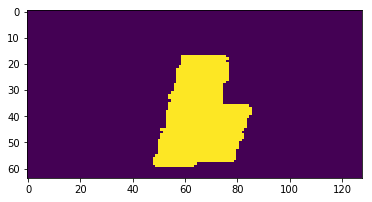

[ 3  2 10 10 10]


In [30]:
rd = 10
sample = images1[rd].copy()
print("sample", sample.shape)
print(np.unique(sample))
# sample = sample.reshape(sample.shape[0], sample.shape[1], 3).astype(np.float32)
# sample /= 255
plt.imshow(sample/255)
plt.show()

print(masks1[rd].shape)
plt.imshow(masks1[rd][0])
plt.show()
plt.imshow(masks1[rd][1])
plt.show()
print(labels1[rd])

In [31]:
print(np.array(images).shape, np.array(masks).shape, labels.shape)
print(train_set.shape, train_set_masks.shape, train_set_labels.shape)

(56, 64, 128, 3) (56, 5, 64, 128) (56, 5)
(55000, 64, 128, 3) (55000, 5, 64, 128) (55000, 5)


In [36]:
X_train = np.concatenate((images, train_set))
print(X_train.shape)

X_masks = np.concatenate((masks, train_set_masks))
print(X_masks.shape)

X_labels = np.concatenate((labels, train_set_labels))
print(X_labels.shape)

(55056, 64, 128, 3)
(55056, 5, 64, 128)
(55056, 5)


array([  0., 180., 181., 182., 183., 184., 185., 186., 187., 188., 189.,
       190., 191., 192., 193., 194., 195., 196., 197., 198., 199., 200.,
       201., 202., 203., 204.], dtype=float32)

In [40]:
np.save('handwriting-train-images.npy', X_train)
np.save('handwriting-train-masks.npy', X_masks)
np.save('handwriting-train-labels.npy', X_labels)

In [41]:
print(np.array(images1).shape, np.array(masks1).shape, labels1.shape)
print(valid_set.shape, valid_set_masks.shape, valid_set_labels.shape)

(14, 64, 128, 3) (14, 5, 64, 128) (14, 5)
(5000, 64, 128, 3) (5000, 5, 64, 128) (5000, 5)


In [42]:
X_val_train = np.concatenate((images1, valid_set))
print(X_val_train.shape)

X_val_masks = np.concatenate((masks1, valid_set_masks))
print(X_val_masks.shape)

X_val_labels = np.concatenate((labels1, valid_set_labels))
print(X_val_labels.shape)

(5014, 64, 128, 3)
(5014, 5, 64, 128)
(5014, 5)


In [43]:
np.save('handwriting-val-images.npy', X_val_train)
np.save('handwriting-val-masks.npy', X_val_masks)
np.save('handwriting-val-labels.npy', X_val_labels)